If you're running in a separate notebook (e.g., Google Colab), go through and un-comment the cells below as required. Also make sure to set the runtime before running the notebook.

In [1]:
# !pip install numpy matplotlib corner h5ify

In [2]:
# # If you're running on CPU:
# !pip install jax numypro

# # If you're running on GPU
# !pip install -U 'jax[cuda12]'
# !pip install 'numpyro[cuda]' -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [3]:
# !pip install wcosmo jax_tqdm equinox equinox optax flowjax

In [4]:
# # Download software injections and parameter estimation from LVK O3:
# !mkdir -p data
# !wget https://github.com/mdmould/ml-gw-pop/blob/main/data/vt.h5 -P data
# !wget https://github.com/mdmould/ml-gw-pop/blob/main/data/pe.h5 -P data

In [5]:
# If you're running on a shared cluster and want to limit the resources you take up:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NPROC'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## Simulation-based population model

In this notebook, we'll train a normalizing flow to learn an astrophysical population model using simulations. Then, we'll use it for population inference on a catalogue of gravitational-wave observations.

We'll use [JAX](https://github.com/jax-ml/jax) as the main workhorse behind this notebook.

In [6]:
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)

In [7]:
# check for GPU devices
jax.devices()

[CudaDevice(id=0)]

#### Population model

First, let's define the population model that we'll use for the astrophysical distribution of sources.

As an example, we'll construct a simple simulated model of "hierarchical" mergers, where some of the population of black holes are the products of previous black-hole mergers. We call "first-generation" (1G) black holes those that are born from stars and "second-generation" (2G) black holes those that are born from black-hole mergers.

Some of the ideas are based on our paper ["Deep learning and Bayesian inference of gravitational-wave populations: Hierarchical black-hole mergers" (arXiv:2203.03651)](https://arxiv.org/abs/2203.03651) and [code](http://github.com/mdmould/qluster) called ["QLUSTER: quick clusters of merging binary black holes" (arXiv:2305.04987)](https://arxiv.org/abs/2305.04987).

Below are some utilities we'll use to build the population model.

In [8]:
# tapering functions

def cubic_filter(x):
    return (3 - 2 * x) * x**2 * (0 <= x) * (x <= 1) + (1 < x)

def highpass(x, xmin, dmin):
    return cubic_filter((x - xmin) / dmin)

def lowpass(x, xmax, dmax):
    return highpass(x, xmax, -dmax)

def bandpass(x, xmin, xmax, dmin, dmax):
    return highpass(x, xmin, dmin) * lowpass(x, xmax, dmax)

In [9]:
# power law functions

def powerlaw_integral(x, alpha, loc, delta):
    a, c, d = alpha, loc, delta
    return (
        3 * (2 * c + (4 + a) * d)
        * (c**2 / (1 + a) - 2 * c * x / (2 + a) + x**2 / (3 + a))
        - 2 * (x - c)**3
    ) * x**(1 + a) / (4 + a) / d**3

def bandpass_powerlaw(x, alpha, xmin, xmax, dmin, dmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = x**alpha * bandpass(x, xmin, xmax, dmin, dmax)
    norm = (
        - powerlaw_integral(xmin, alpha, xmin, dmin)
        + powerlaw_integral(xmin + dmin, alpha, xmin, dmin)
        - (xmin + dmin)**(alpha + 1) / (alpha + 1)
        + (xmax - dmax)**(alpha + 1) / (alpha + 1)
        - powerlaw_integral(xmax - dmax, alpha, xmax, -dmax)
        + powerlaw_integral(xmax, alpha, xmax, -dmax)
    )
    return cut * shape / norm

In [10]:
# Gaussian functions

def truncated_normal(x, mu, sigma, xmin, xmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = jax.scipy.stats.norm.pdf(x, mu, sigma)
    norm = (
        - jax.scipy.stats.norm.cdf(xmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax, mu, sigma)
    )
    return cut * shape / norm

def normal_integral(x, mu, sigma, loc, delta):
    m, s, c, d = mu, sigma, loc, delta
    return (
        jnp.exp(-(x - m)**2 / 2 / s ** 2) * (2 / jnp.pi)**0.5 * s * (
            6 * c * (c + d - m - x)
            - 3 * d * (m + x)
            + 2 * (m**2 + 2 * s**2 + m * x + x**2)
        )
        - jax.lax.erf((m - x) / s / 2**0.5) * (
            (2 * c + 3 * d - 2 * m) * (c - m)**2
            + 3 * s**2 * (2 * c + d - 2 * m)
        )
    ) / 2 / d**3

def bandpass_normal(x, mu, sigma, xmin, xmax, dmin, dmax):
    cut = (xmin <= x) * (x <= xmax)
    shape = (
        jax.scipy.stats.norm.pdf(x, mu, sigma)
        * bandpass(x, xmin, xmax, dmin, dmax)
    )
    norm = (
        - normal_integral(xmin, mu, sigma, xmin, dmin)
        + normal_integral(xmin + dmin, mu, sigma, xmin, dmin)
        - jax.scipy.stats.norm.cdf(xmin + dmin, mu, sigma)
        + jax.scipy.stats.norm.cdf(xmax - dmax, mu, sigma)
        - normal_integral(xmax - dmax, mu, sigma, xmax, -dmax)
        + normal_integral(xmax, mu, sigma, xmax, -dmax)
    )
    return cut * shape / norm

We'll make the simplifying assumption that the merger rate over comoving volume and source-frame time has a shared redshift evolution for all sources.

We'll use [wcosmo](https://github.com/ColmTalbot/wcosmo), which is a nice package for cosmological calculations in JAX.

In [11]:
import wcosmo
wcosmo.disable_units()

In [12]:
def shape_z(z, parameters):
    return (1 + z)**parameters['gamma']

def pdf_z(z, parameters):
    zmax = 2
    fn = lambda z: (
        shape_z(z, parameters)
        * wcosmo.Planck15.differential_comoving_volume(z) * 4 * jnp.pi / 1e9
    )
    cut = (0 < z) * (z <= zmax)
    shape = fn(z)
    zz = jnp.linspace(0, zmax, 10_000)
    norm = jnp.trapezoid(fn(zz), zz)
    return cut * shape / norm

To build up a population of second-generation mergers, we'll begin by defining the distribution of first-generation mergers. We'll assume that:
- black-hole masses are distributed from a tapered power law with an additional Gaussian peak (similar to the [Power Law + Peak](https://arxiv.org/abs/1801.02699) model), where both components decay to zero after the Gaussian peak - this is a mock up of the effect of the (pulsational) pair instability;
- black-holes spin magnitudes are drawn from a truncated normal distribution;
- spins are isotropic in direction.

In [13]:
def maximum_mass(parameters):
    return parameters['mu_m'] + parameters['sigma_m'] * 3

def pdf_m(m, parameters):
    pl = bandpass_powerlaw(
        m,
        parameters['alpha'],
        parameters['m_min'],
        maximum_mass(parameters),
        parameters['d_min'],
        parameters['sigma_m'] * 3,
    )
    tn = bandpass_normal(
        m,
        parameters['mu_m'],
        parameters['sigma_m'],
        parameters['m_min'],
        maximum_mass(parameters),
        parameters['d_min'],
        parameters['sigma_m'] * 3,
    )
    return (1 - parameters['f_m']) * pl + parameters['f_m'] * tn

In [14]:
import matplotlib.pyplot as plt

Array(0.9999996, dtype=float64)

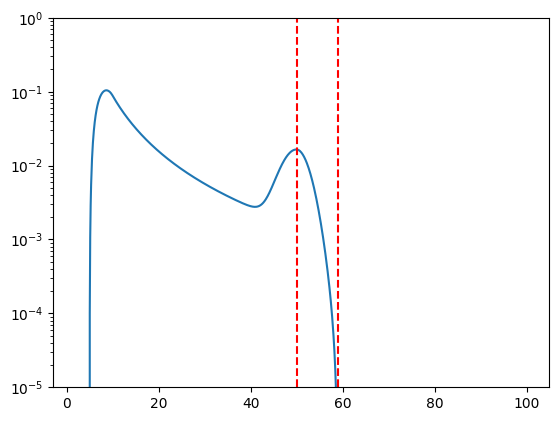

In [15]:
parameters = dict(
    alpha = -2.5,
    m_min = 5,
    d_min = 5,
    mu_m = 50,
    sigma_m = 3,
    f_m = 0.1,
)

m = jnp.linspace(2, 100, 1_000)
p = pdf_m(m, parameters)

plt.plot(m, p)
plt.axvline(parameters['mu_m'], c = 'r', ls = '--')
plt.axvline(maximum_mass(parameters), c = 'r', ls = '--')
plt.semilogy()
plt.ylim(1e-5, 1e0)
jnp.trapezoid(p, m)

To generate training data for our model, we need a function to generate samples for our 1G mergers. We model black holes as being paired according to a power law with slope `beta` in the total binary mass.

In [16]:
def inversion_sampling(key, shape, pdf, x):
    cdf = jnp.cumsum(jnp.diff(x) * (pdf[1:] + pdf[:-1]) / 2)
    cdf = jnp.insert(cdf / cdf[-1], 0, 0)
    u = jax.random.uniform(key, shape)
    return jnp.interp(u, cdf, x)

def sample_m(key, shape, parameters):
    x = jnp.linspace(parameters['m_min'], maximum_mass(parameters), 1_000)
    p = pdf_m(x, parameters)
    return inversion_sampling(key, shape, p, x)

def sample_truncated_normal(key, shape, mu, sigma, lo, hi):
    u = jax.random.uniform(key, shape)
    loc = jax.scipy.stats.norm.cdf(lo, mu, sigma)
    scale = jax.scipy.stats.norm.cdf(hi, mu, sigma) - loc
    return jax.scipy.stats.norm.ppf(u * scale + loc, mu, sigma)

In [17]:
def sample_1g(key, n, parameters):
    # masses
    key, subkey = jax.random.split(key)
    m = sample_m(subkey, (2, n), parameters)
    m1, m2 = m.max(axis = 0), m.min(axis = 0)
    q = m2 / m1

    # spin magnitudes
    key, subkey = jax.random.split(key)
    a1, a2 = sample_truncated_normal(
        subkey, (2, n), parameters['mu_a'], parameters['sigma_a'], 0, 1,
    )

    # spin tilts
    key, subkey = jax.random.split(key)
    c1, c2 = jax.random.uniform(subkey, (2, n), minval = -1, maxval = 1)

    # azimuthal angle
    key, subkey = jax.random.split(key)
    dp = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)

    # pairing function
    pair = (m1 + m2)**parameters['beta']
    key, subkey = jax.random.split(key)
    idxs = jax.random.choice(subkey, n, shape = (n,), p = pair)
    mergers = jnp.array([m1, q, a1, a2, c1, c2, dp])[:, idxs]

    return mergers

Next, we want to sample a population of mergers involving a 2G black hole. We'll just consider binaries in which one black hole is 1G and the other is 2G (1G+2G binary).

To do so, we need a function to output the properties of black-hole merger remnants from input pre-merger binary properties. Importantly, the remnant recieves a recoil - or "kick" - that imparts a velocity, which can eject it from its host environment and thus prevent it from participating in 2G mergers.

We follow the fitting formulae to numerical-relativity simulations included in the [precession](https://arxiv.org/abs/1605.01067) Python [package](https://github.com/dgerosa/precession), but with a minimal re-implementation in JAX (I've removed the internal vectorization, which can be done automatically with `jax.vmap`, and fixed to the default spin and kick options).

In [18]:
def eval_eta(q):
    return q / (1 + q)**2

def eval_theta12(theta1, theta2, deltaphi):
    return jnp.arccos(
        jnp.sin(theta1) * jnp.sin(theta2) * jnp.cos(deltaphi)
        + jnp.cos(theta1) * jnp.cos(theta2)
    )

def angles_to_Lframe(theta1, theta2, deltaphi, r, q, chi1, chi2):
    L = r**0.5 * q / (1 + q)**2
    S1 = chi1 / (1 + q)**2
    S2 = chi2 * q**2 / (1 + q)**2

    Lx = 0
    Ly = 0
    Lz = L
    Lvec = jnp.array([Lx, Ly, Lz])

    S1x = S1 * jnp.sin(theta1)
    S1y = 0
    S1z = S1 * jnp.cos(theta1)
    S1vec = jnp.array([S1x, S1y, S1z])

    S2x = S2 * jnp.sin(theta2) * jnp.cos(deltaphi)
    S2y = S2 * jnp.sin(theta2) * jnp.sin(deltaphi)
    S2z = S2 * jnp.cos(theta2)
    S2vec = jnp.array([S2x, S2y, S2z])

    return Lvec, S1vec, S2vec

In [19]:
def remnant_mass(theta1, theta2, q, chi1, chi2):
    eta = eval_eta(q)

    chit_par =  ( chi2*q**2 * jnp.cos(theta2) + chi1*jnp.cos(theta1) ) / (1+q)**2

    #Final mass. Barausse Morozova Rezzolla 2012
    p0 = 0.04827
    p1 = 0.01707
    Z1 = 1 + (1-chit_par**2)**(1/3)* ((1+chit_par)**(1/3)+(1-chit_par)**(1/3))
    Z2 = (3* chit_par**2 + Z1**2)**(1/2)
    risco = 3 + Z2 - jnp.sign(chit_par) * ((3-Z1)*(3+Z1+2*Z2))**(1/2)
    Eisco = (1-2/(3*risco))**(1/2)
    #Radiated energy, in units of the initial total mass of the binary
    Erad = eta*(1-Eisco) + 4* eta**2 * (4*p0+16*p1*chit_par*(chit_par+1)+Eisco-1)
    Mfin = 1- Erad # Final mass

    return Mfin

In [20]:
def remnant_spin(theta1, theta2, deltaphi, q, chi1, chi2):
    eta = eval_eta(q)

    kfit = jnp.array( [[jnp.nan, 3.39221, 4.48865, -5.77101, -13.0459] ,
                      [35.1278, -72.9336, -86.0036, 93.7371, 200.975],
                      [-146.822, 387.184, 447.009, -467.383, -884.339],
                      [223.911, -648.502, -697.177, 753.738, 1166.89]])
    xifit = 0.474046

    # Calculate K00 from Eq 11
    kfit = kfit.at[0,0].set(4**2 * ( 0.68646 - jnp.sum( kfit[1:,0] /(4**(3+jnp.arange(kfit.shape[0]-1)))) - (3**0.5)/2))

    theta12 = eval_theta12(theta1, theta2, deltaphi)

    eps1 = 0.024
    eps2 = 0.024
    eps12 = 0
    theta1 = theta1 + eps1 * jnp.sin(theta1)
    theta2 = theta2 + eps2 * jnp.sin(theta2)
    theta12 = theta12 + eps12 * jnp.sin(theta12)

    # Eq. 14 - 15
    atot = ( chi1*jnp.cos(theta1) + chi2*jnp.cos(theta2)*q**2 ) / (1+q)**2
    aeff = atot + xifit*eta* ( chi1*jnp.cos(theta1) + chi2*jnp.cos(theta2) )

    # Eq. 2 - 6 evaluated at aeff, as specified in Eq. 11
    Z1= 1 + (1-(aeff**2))**(1/3) * ( (1+aeff)**(1/3) + (1-aeff)**(1/3) )
    Z2= ( (3*aeff**2) + (Z1**2) )**(1/2)
    risco= 3 + Z2 - jnp.sign(aeff) * ( (3-Z1)*(3+Z1+2*Z2) )**(1/2)
    Eisco=(1-2/(3*risco))**(1/2)
    Lisco = (2/(3*(3**(1/2)))) * ( 1 + 2*(3*risco - 2 )**(1/2) )

    # Eq. 13
    etatoi = eta**(1+jnp.arange(kfit.shape[0]))
    innersum = jnp.sum(kfit.T * etatoi,axis=1)
    aefftoj = aeff**(jnp.arange(kfit.shape[1]))
    sumell = jnp.sum(innersum  * aefftoj,axis=0)
    ell = jnp.abs( Lisco  - 2*atot*(Eisco-1)  + sumell )

    # Eq. 16
    chifin = (1/(1+q)**2) * ( chi1**2 + (chi2**2)*(q**4)  + 2*chi1*chi2*(q**2)*jnp.cos(theta12)
            + 2*(chi1*jnp.cos(theta1) + chi2*(q**2)*jnp.cos(theta2))*ell*q + ((ell*q)**2)  )**(1/2)

    return jnp.minimum(chifin,1)

In [21]:
def remnant_kick(bigTheta, theta1, theta2, deltaphi, q, chi1, chi2):
# kms=False, maxphase=False, superkick=True, hangupkick=True, crosskick=True, full_output=False):

    eta = eval_eta(q)

    Lvec, S1vec, S2vec = angles_to_Lframe(theta1, theta2, deltaphi, 1, q, chi1, chi2)
    hatL = Lvec / jnp.linalg.norm(Lvec)
    hatS1 = S1vec / jnp.linalg.norm(S1vec)
    hatS2 = S2vec / jnp.linalg.norm(S2vec)

    #More spin parameters.
    Delta = - 1/(1+q) * (q*chi2*hatS2 - chi1*hatS1)
    Delta_par = jnp.dot(Delta, hatL)
    Delta_perp = jnp.linalg.norm(jnp.cross(Delta, hatL))
    chit = 1/(1+q)**2 * (chi2*q**2*hatS2 + chi1*hatS1)
    chit_par = jnp.dot(chit, hatL)
    chit_perp = jnp.linalg.norm(jnp.cross(chit, hatL))

    #Coefficients are quoted in km/s
    #vm and vperp from Kesden at 2010a. vpar from Lousto Zlochower 2013
    zeta=jnp.radians(145)
    A=1.2e4
    B=-0.93
    H=6.9e3

    #Multiply by 0/1 boolean flags to select terms
    V11 = 3677.76
    VA = 2481.21
    VB = 1792.45
    VC = 1506.52
    C2 = 1140
    C3 = 2481

    # #maxkick
    # bigTheta=np.random.uniform(0, 2*np.pi,q.shape) * (not maxphase)

    vm = A * eta**2 * (1+B*eta) * (1-q)/(1+q)
    vperp = H * eta**2 * Delta_par
    vpar = 16*eta**2 * (Delta_perp * (V11 + 2*VA*chit_par + 4*VB*chit_par**2 + 8*VC*chit_par**3) + chit_perp * Delta_par * (2*C2 + 4*C3*chit_par)) * jnp.cos(bigTheta)
    kick = jnp.array([vm+vperp*jnp.cos(zeta),vperp*jnp.sin(zeta),vpar]).T

    # if not kms:
    #     kick = kick/299792.458 # speed of light in km/s

    vk = jnp.linalg.norm(kick)

    return vk

Let's check this matches the original code (note that [precession](https://github.com/dgerosa/precession) resamples the additional angle $\Theta$ internally, but above we made it an explicit input; we seed the random sampling below to ensure the same values are used).

In [22]:
import precession
from corner import corner

In [23]:
n = 10_000
np.random.seed(0)
bigTheta = np.random.uniform(0, 2 * np.pi, n)
theta1 = np.random.uniform(0, np.pi, n)
theta2 = np.random.uniform(0, np.pi, n)
deltaphi = np.random.uniform(0, 2 * np.pi, n)
q = np.random.uniform(0.1, 1, n)
chi1 = np.random.uniform(0, 1, n)
chi2 = np.random.uniform(0, 1, n)

In [24]:
np.random.seed(0)
og = np.array([
    precession.remnantmass(theta1, theta1, q, chi1, chi2),
    precession.remnantspin(theta1, theta1, deltaphi, q, chi1, chi2),
    precession.remnantkick(theta1, theta1, deltaphi, q, chi1, chi2, kms = True),
])

In [25]:
re = np.array([
    jax.vmap(remnant_mass)(theta1, theta1, q, chi1, chi2),
    jax.vmap(remnant_spin)(theta1, theta1, deltaphi, q, chi1, chi2),
    jax.vmap(remnant_kick)(bigTheta, theta1, theta1, deltaphi, q, chi1, chi2),
])

In [26]:
np.allclose(og, re)

True

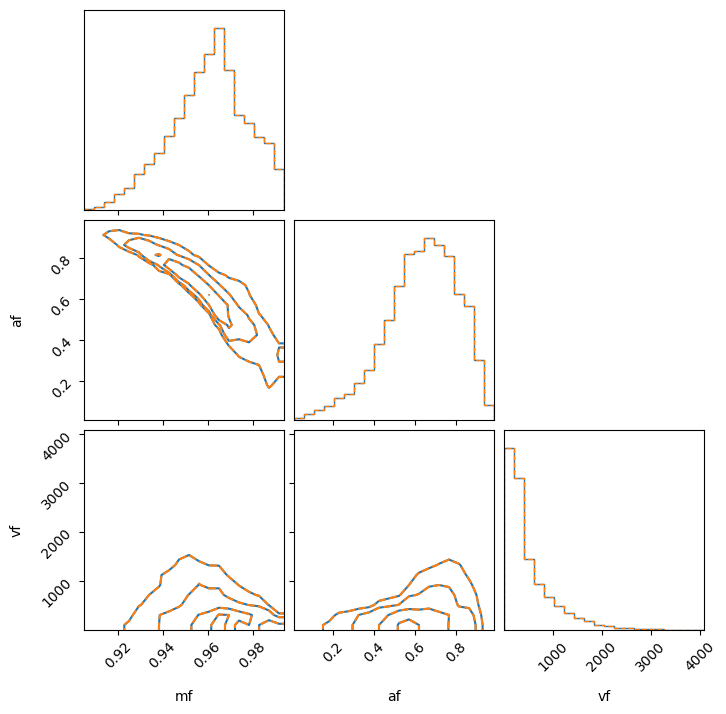

In [27]:
fig = None
for i, (samples, ls) in enumerate(zip((og, re), ('-', '--'))):
    fig = corner(
        samples.T, labels = ('mf', 'af', 'vf'), fig = fig,
        plot_datapoints = False, plot_density = False,
        plot_contours = True, fill_contours = False, no_fill_contours = True,
        hist_kwargs = dict(density = True, color = f'C{i}', ls = ls),
        contour_kwargs = dict(colors = [f'C{i}'], linestyles = ls),
    )

Next, we'll combine the 1G population with the remnant fits to produce a population of 1G+2G black-hole mergers.

For the 2G black holes, we will assume all mergers occur in an environment with escape speed `v_esc`; remnants that recieve a kick larger than `v_esc` are "ejected" and do not lead to 1G+2G mergers.

The 2G black holes that are retained will pair with 1G black holes, acording again to a power law in the total mass, this time with slope `gamma`.

In [28]:
def remnant(m1, q, a1, a2, c1, c2, dp, th):
    t1, t2 = jnp.arccos(c1), jnp.arccos(c2)
    mf = remnant_mass(t1, t2, q, a1, a2) * m1 * (1 + q)
    af = remnant_spin(t1, t2, dp, q, a1, a2)
    vf = remnant_kick(th, t1, t2, dp, q, a1, a2)
    return mf, af, vf

In [29]:
def sample_2g(key, mf, af, vf, parameters):
    n = jnp.array([mf, af, vf]).shape[1]

    # 1g mass
    key, subkey = jax.random.split(key)
    m = sample_m(subkey, (n,), parameters)

    # ejection and pairing
    key, subkey = jax.random.split(key)
    pair = (vf < parameters['v_esc']) * (mf + m)**parameters['gamma']
    idxs = jax.random.choice(subkey, n, shape = (n,), p = pair)

    # masses
    m_2g = jnp.stack([mf, m])
    sort = jnp.argsort(m_2g, axis = 0)
    m2_2g, m1_2g = jnp.take_along_axis(m_2g, sort, axis = 0)
    q_2g = m2_2g / m1_2g

    # spin magnitudes
    key, subkey = jax.random.split(key)
    a = sample_truncated_normal(
        subkey, (n,), parameters['mu_a'], parameters['sigma_a'], 0, 1,
    )
    a2_2g, a1_2g = jnp.take_along_axis(jnp.stack([af, a]), sort, axis = 0)

    # spin tilts
    key, subkey = jax.random.split(key)
    c1_2g, c2_2g = jax.random.uniform(subkey, (2, n), minval = -1, maxval = 1)

    # azimuthal spin
    key, subkey = jax.random.split(key)
    dp_2g = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)

    mergers = jnp.array([m1_2g, q_2g, a1_2g, a2_2g, c1_2g, c2_2g, dp_2g])

    return mergers

Now, to combine these ingredients to sample our overall population.

The last assumption we'll make is that the overall fraction of 1G+2G mergers is proportional to the fraction of 2G black holes that are retained (i.e., with kicks smaller than `v_esc`), with constant of proportionality `r_2g`.

As we assume that the spin angles are isotropic, we will just model directly the masses and spin magnitudes.

In [30]:
dim = 4

In [31]:
def sample_mergers(key, n, parameters):
    # 1g+1g mergers
    key, subkey = jax.random.split(key)
    mergers = sample_1g(subkey, n, parameters)

    # 1g+1g remnants (2g)
    key, subkey = jax.random.split(key)
    th = jax.random.uniform(subkey, (n,), minval = 0, maxval = 2 * jnp.pi)
    mf, af, vf = jax.vmap(remnant)(*mergers, th)

    # 1g+2g mergers
    key, subkey = jax.random.split(key)
    mergers_2g = sample_2g(subkey, mf, af, vf, parameters)

    # mixing
    key, subkey = jax.random.split(key)
    f = (vf < parameters['v_esc']) * parameters['r_2g']
    b = jax.random.binomial(subkey, n = 1, p = f, shape = (n,))
    mergers = jnp.where(b, mergers_2g, mergers)

    # we'll just fit masses and spin magnitudes as the other angles are
    # mostly independent
    return mergers[:4].T

Let's check how our simulated model looks on an example.

Is this simulated model realistic? No. Will it do for this tutorial? Probably.

In [32]:
parameters = dict(
    alpha = -2.5,
    m_min = 5,
    d_min = 5,
    mu_m = 35,
    sigma_m = 3,
    f_m = 0.1,
    mu_a = 0.1,
    sigma_a = 0.2,
    beta = 0,
    v_esc = 500,
    gamma = 0,
    r_2g = 0.1,
)

In [33]:
mergers = sample_mergers(jax.random.key(0), 100_000, parameters)

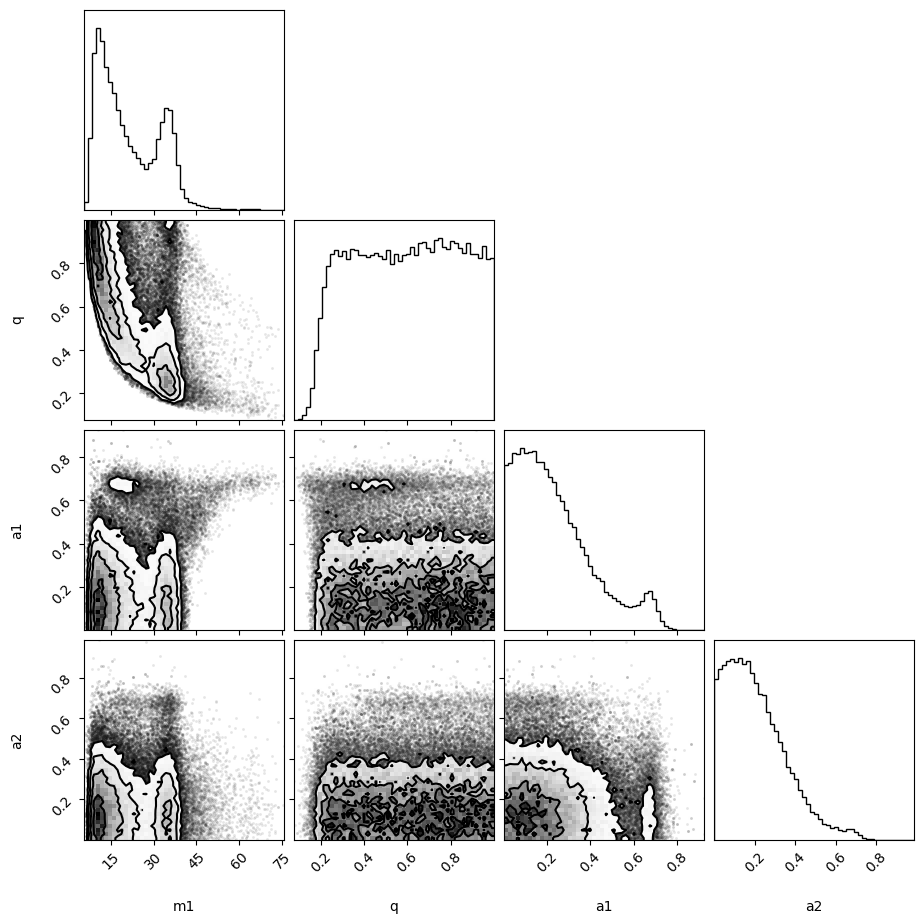

In [34]:
fig = corner(np.array(mergers), bins = 50, labels = ('m1', 'q', 'a1', 'a2'));

#### Priors

Moving on, the next thing we need is a prior distribution of model parameters over which we will sample when training the normalizing flow.

In [36]:
import numpyro

In [37]:
priors = dict(
    alpha = numpyro.distributions.Uniform(-5, 5),
    m_min = numpyro.distributions.Uniform(2, 10),
    d_min = numpyro.distributions.Uniform(0, 10),
    mu_m = numpyro.distributions.Uniform(20, 60),
    sigma_m = numpyro.distributions.Uniform(1, 5),
    f_m = numpyro.distributions.Uniform(0, 0.2),
    mu_a = numpyro.distributions.Uniform(0, 0.5),
    sigma_a = numpyro.distributions.Uniform(0.1, 0.5),
    beta = numpyro.distributions.Uniform(-5, 5),
    v_esc = numpyro.distributions.Uniform(0, 1_000),
    gamma = numpyro.distributions.Uniform(-5, 5),
    r_2g = numpyro.distributions.Uniform(0, 0.5),
)

In [38]:
cond_dim = len(priors)

In [39]:
def sample_parameters(key):
    keys = jax.random.split(key, len(priors))
    return {k: priors[k].sample(key) for k, key in zip(priors, keys)}

#### Normalizing flow

Now let's set up the model that we'll train. We'll use a [block neural autoregressive flow](https://arxiv.org/abs/1904.04676) to approximate the simulations. There's a nice library called [flowjax](https://github.com/danielward27/flowjax) to do normalizing flows in JAX that we'll use. This is built on top of [equinox](https://github.com/patrick-kidger/equinox), which will handle our neural networks.

If you aren't familiar with normalizing flows, the (very brief) idea is that you can construct a probability distribution by transforming a simple known distribution (such as a standard normal distribution) with an invertible and differentiable function using the change-of-variables formula. For normalizing flows, that function is parametrized by a neural network, which is what makes the transformation flexible.

The transformation is trained so that the output distribution best matches some target distribution - in our case the simulation-based population model.

In [40]:
import equinox
from flowjax.distributions import StandardNormal
from flowjax.flows import block_neural_autoregressive_flow

In [41]:
flow_init = block_neural_autoregressive_flow(
    key = jax.random.key(0),
    base_dist = StandardNormal(shape = (dim,)),
    cond_dim = cond_dim,
    invert = True,
)

It works by splitting pytrees - nested python containers of JAX arrays - into trainable and non-trainable subsets.

In [42]:
params_init, static = equinox.partition(flow_init, equinox.is_inexact_array)

We can easily get the number of parameters (weights and biases of the neural networks) in our model.

In [43]:
array_init, unravel = jax.flatten_util.ravel_pytree(params_init)
array_init.size

712

We should take care that our normalizing flow is defined on the parameter domain we want it to be. In particular, our priors impose bounds on the range of values that can be taken. Therefore, we'll add some additional transformations to ensure those bounds are respected. These transformation are fixed and not trainable, unlike the flow transformations.

(We clip the inputs as the bounding transformations are asymptotic, meaning the extremal values are invalid.)

In [44]:
lo = jnp.array([2, 0, 0, 0])
hi = jnp.array([200, 1, 1, 1])

def inverse_mergers(mergers):
    x = (mergers - lo) / (hi - lo)
    x = jnp.clip(x, 1e-3, 1 - 1e-3)
    return jax.scipy.special.logit(x)

def forward_mergers(x):
    return jax.nn.sigmoid(x) * (hi - lo) + lo

Though not strictly necessary, we'll also do this for the observations so that all inputs to the flow have roughly the same range of numerical values.

In [45]:
def inverse_parameters(parameters):
    x = jnp.array([
        (parameters[k] - priors[k].low) / (priors[k].high - priors[k].low)
        for k in priors
    ])
    x = jnp.clip(x, 1e-3, 1 - 1e-3)
    x = jax.scipy.stats.norm.ppf(x)
    return x

#### Training

On to training the model.

To train the flow, we need to define a loss function to minimize with respect to the neural-network parameters. The training objective for flows can be thought of in several equivalent ways, including the Kullback-Leibler divergence, the cross entropy, and the likelihood of the training data.

The upshot is that the probability density predicted by the flow can be matched to the joint distribution of population-model parameters and single-event source parameters.

Below, we define the loss function and training loop to do this.

First, let's set some training parameters. Note that we will train the flow by showing it only one simulation at a time, i.e., one value of `parameters` that produces an amount `batch_size` of mergers.

We'll use [optax](https://github.com/google-deepmind/optax) to update the neural network.

In [46]:
import optax

In [47]:
batch_size = 1_000
steps = 10_000
learning_rate = 1e-2
optimizer = optax.adam(learning_rate)

In [48]:
# wrap the sampling and bounding functions together
def sample(key):
    key, subkey = jax.random.split(key)
    parameters = sample_parameters(subkey)
    c = inverse_parameters(parameters)
    key, subkey = jax.random.split(key)
    mergers = sample_mergers(subkey, batch_size, parameters)
    x = inverse_mergers(mergers)
    return x, c

# the average likelihood of mergers from a single simulation
def loss_fn(params, key):
    flow = equinox.combine(params, static)
    x, c = sample(key)
    return -flow.log_prob(x, c).mean()

In [53]:
# if things go wrong and the loss becomes non-finite,
# then return to the best last update
def check_finite(carry, loss):
    key, params, state, best_params, best_state, best_loss = carry
    params, state = jax.lax.cond(
        jnp.isfinite(loss),
        lambda: (params, state),
        lambda: (best_params, best_state),
    )
    return key, params, state, best_params, best_state, best_loss

# keep track of the flow with the best loss value
def check_best(carry, loss):
    key, params, state, best_params, best_state, best_loss = carry
    best_params, best_state, best_loss = jax.lax.cond(
        loss < best_loss,
        lambda: (params, state, loss),
        lambda: (best_params, best_state, best_loss),
    )
    return key, params, state, best_params, best_state, best_loss

# function to update the neural-network parameters
def update(carry, step):
    key, params, state, best_params, best_state, best_loss = carry
    key, subkey = jax.random.split(key)
    loss, grad = equinox.filter_value_and_grad(loss_fn)(params, subkey)
    updates, state = optimizer.update(grad, state, params)
    params = equinox.apply_updates(params, updates)
    carry = key, params, state, best_params, best_state, best_loss
    carry = check_finite(carry, loss)
    carry = check_best(carry, loss)
    return carry, loss

Another handy package is [jax_tqdm](https://github.com/jeremiecoullon/jax-tqdm) to add progress bar to JAX loops.

In [54]:
import jax_tqdm

In [55]:
update = jax_tqdm.scan_tqdm(steps, print_rate = 100, tqdm_type = 'std')(update)

Now let's train it!

In [56]:
# finally, the training loop (written without Python loops using JAX)
state = optimizer.init(params_init)
carry = (
    jax.random.key(100),
    params_init,
    state,
    params_init,
    state,
    jnp.inf,
)
carry, losses = jax.lax.scan(update, carry, jnp.arange(steps))
key, params, state, best_params, best_state, best_loss = carry

Running for 10,000 iterations: 100%|█████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 626.92it/s]


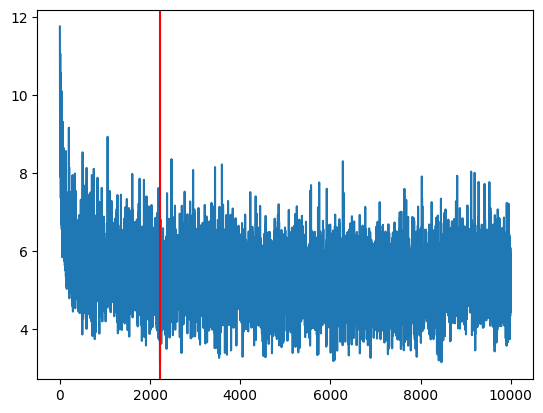

In [57]:
# the loss values over training steps
plt.plot(losses);
plt.axvline(losses.argmin(), c = 'r');

We can reconstruct the flow at both the last training step and the step with the best loss (but note that, due to sampling noise, the lowest loss value is not necessarily the one producing the "best" trained model).

In [58]:
last_flow = equinox.combine(params, static)
best_flow = equinox.combine(best_params, static)

How did the training do? Let's compre the trained flow to the actual simulated model.

In [59]:
from corner import corner

In [76]:
# # to select particular population parameters, uncomment this
# parameters = dict(
#     alpha = -2.5,
#     m_min = 5,
#     m_max = 60,
#     d_min = 5,
#     d_max = 5,
#     mu_m = 35,
#     sigma_m = 3,
#     f_m = 0.1,
#     beta = 0,
#     mu_a = 0.1,
#     sigma_a = 0.2,
#     v_esc = 100_000,
#     gamma = 0,
#     r_2g = 0.5,
# )

# # to select random population parameters, uncomment this
parameters = sample_parameters(jax.random.key(np.random.randint(1e9)))

c = inverse_parameters(parameters)

mergers = sample_mergers(jax.random.key(43), 10_000, parameters)

x = last_flow.sample(jax.random.key(44), (10_000,), condition = c)
last_flow_mergers = forward_mergers(x)

x = best_flow.sample(jax.random.key(44), (10_000,), condition = c)
best_flow_mergers = forward_mergers(x)

In [77]:
parameters

{'alpha': Array(0.66768443, dtype=float64),
 'm_min': Array(3.28478972, dtype=float64),
 'd_min': Array(5.06295552, dtype=float64),
 'mu_m': Array(47.21395588, dtype=float64),
 'sigma_m': Array(1.16099549, dtype=float64),
 'f_m': Array(0.19436322, dtype=float64),
 'mu_a': Array(0.12806348, dtype=float64),
 'sigma_a': Array(0.45244958, dtype=float64),
 'beta': Array(1.96061883, dtype=float64),
 'v_esc': Array(887.3426342, dtype=float64),
 'gamma': Array(0.66290378, dtype=float64),
 'r_2g': Array(0.01187934, dtype=float64)}

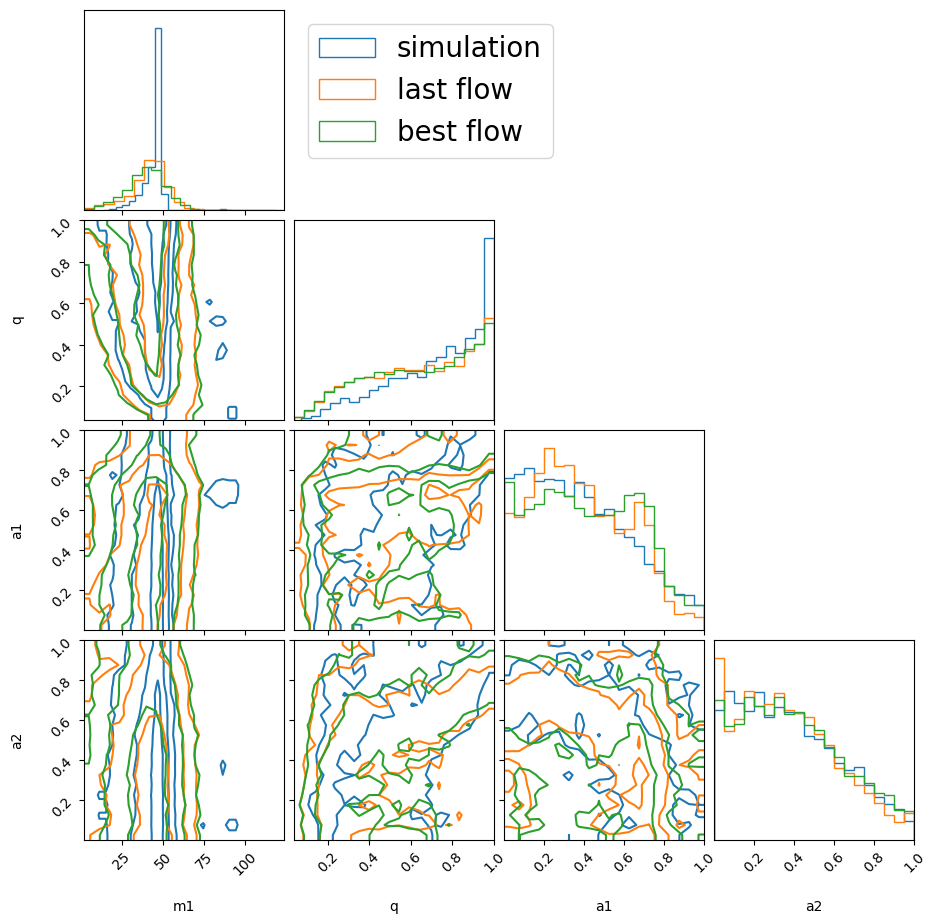

In [79]:
fig = None

for i, samples in enumerate((mergers, last_flow_mergers, best_flow_mergers)):
    fig = corner(
        np.array(samples), labels = ('m1', 'q', 'a1', 'a2'),
        fig = fig, plot_datapoints = False, plot_density = False,
        plot_contours = True, fill_contours = False, no_fill_contours = True,
        hist_kwargs = dict(density = True, color = f'C{i}'),
        contour_kwargs = dict(colors = [f'C{i}']),
        # range = np.transpose([lo, hi]),
        levels = (0.5, 0.9, 0.99), bins = 20, smooth = 0.5,
    )

for i in range(dim):
    ax = fig.axes[i + dim * i]
    ylim = max(patch.xy[:, 1].max() for patch in ax.patches)
    ax.set_ylim(0, ylim * 1.1)

fig.axes[1].legend(
    handles = fig.axes[0].patches,
    labels = ('simulation', 'last flow', 'best flow'),
    fontsize = 20,
    loc = 'upper left',
);

#### Data

Now we want to use our model to analyze real gravitational-wave observations and infer the population parameters that best match the observations.

We will perform population inference on the catalogue of black-hole mergers with false-alarm rates > 1/year from O3. Below, we load in pre-prepared parameter estimation results for those events and a set of software injections that we can use to estimate selection effects (the scripts in the `data/` folder were used to download and prepare the data).

In [64]:
import h5ify

In [65]:
injections = h5ify.load('data/vt.h5')
injections = {
    k: jnp.array(injections[k], dtype = jnp.float64).squeeze()
    for k in injections
}

In [66]:
injections.keys()

dict_keys(['a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'mass_1_source', 'mass_ratio', 'prior', 'redshift', 'time', 'total'])

In [67]:
posteriors = h5ify.load('data/pe.h5')
posteriors = {
    k: jnp.array([posteriors[event][k] for event in sorted(posteriors)])
    for k in posteriors[list(posteriors)[0]]
}

In [68]:
posteriors.keys()

dict_keys(['a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'mass_1_source', 'mass_ratio', 'prior', 'redshift'])

#### Likelihood

How likely is it that our population model is responsible for the observed data?

Below we code up the gravitational-wave population likelihood; see, e.g.,

- https://arxiv.org/abs/1809.02063,
- https://arxiv.org/abs/2007.05579,
- https://arxiv.org/abs/2410.19145.

In particular, the likelihood function is approximated with several Monte Carlo integrals, which introduces additional statistical variance (https://arxiv.org/abs/1904.10879, https://arxiv.org/abs/2204.00461, https://arxiv.org/abs/2304.06138). We make sure to keep track of this variance below.

In [70]:
# ln(mean) and variance of ln(mean)
def ln_mean_and_variance(ln_weights, n):
    ln_sum = jax.nn.logsumexp(ln_weights, axis = -1)
    ln_mean = ln_sum - jnp.log(n)
    ess = jnp.exp(2 * ln_sum - jax.nn.logsumexp(2 * ln_weights, axis = -1))
    variance = 1 / ess - 1 / n
    return ln_mean, variance

In [145]:
def ln_likelihood_and_variance(posteriors, injections, ln_density, parameters):
    ln_pe_weights = ln_density(posteriors, parameters) - jnp.log(posteriors['prior'])
    ln_vt_weights = ln_density(injections, parameters) - jnp.log(injections['prior'])
    num_obs, num_pe = ln_pe_weights.shape
    ln_lkls, pe_variances = ln_mean_and_variance(ln_pe_weights, num_pe)
    ln_pdet, vt_variance = ln_mean_and_variance(ln_vt_weights, injections['total'])
    ln_lkl = ln_lkls.sum() - ln_pdet * num_obs
    variance = pe_variances.sum() + vt_variance * num_obs**2
    # ln_lkl = jnp.nan_to_num(ln_lkl, nan = -jnp.inf)
    # variance = jnp.nan_to_num(variance, nan = jnp.inf)
    return ln_lkl, variance

#### Inference

Now we'll draw samples from the posterior distributions using Hamiltonian Monte Carlo in [numpyro](https://num.pyro.ai/en/latest/mcmc.html).

Pick either the last or "best" flow below.

In [146]:
flow = last_flow
# flow = best_flow

For convenience, we'll combine the fixed transformations that were used to transform the training data into the normalizing flow model.

Note that we'll not include the clipping below - this introduces a slight mismatch between the training model and inference model, but it's probably (hopefully?) a small difference that's fine in practice.

In [147]:
from flowjax.bijections import Affine, Sigmoid, Chain
from flowjax.distributions import Transformed

In [148]:
bijection = Chain([Sigmoid(shape = (dim,)), Affine(loc = lo, scale = hi - lo)])
bijection = Chain([flow.bijection, bijection])
flow = Transformed(flow.base_dist, bijection)

In [149]:
def ln_density(data, parameters):
    x = jnp.array(
        [data['mass_1_source'], data['mass_ratio'], data['a_1'], data['a_2']],
    )
    shape = x.shape[1:]
    x = jnp.moveaxis(x, 0, -1).reshape(-1, dim)
    c = inverse_parameters(parameters)
    return (
        flow.log_prob(x, c).reshape(shape)
        + jnp.log(pdf_z(data['redshift'], parameters))
    )

For the inference prior, we'll just take the same as we used for the training prior - but these do not need to be the same.

We might consider instead making the inference prior a subset of the training prior, because neural networks tend to perform worse near the edges of the parameter space in which they were trained and where they begin to extrapolate. Or tailoring the training prior to favour harder-to-learn parameter regions.

In [150]:
def sample_reparam(name, dist, **args):
    base = numpyro.distributions.Normal()
    z = numpyro.sample(f'_{name}', base, **args)
    return numpyro.deterministic(name, dist.icdf(base.cdf(z)))

def sample_priors(priors, reparam = False):
    if reparam:
        return {k: sample_reparam(k, priors[k]) for k in priors}
    return {k: numpyro.sample(k, priors[k]) for k in priors}

In [151]:
def numpyro_model():
    parameters = sample_priors(priors)
    ln_likelihood, variance = ln_likelihood_and_variance(
        posteriors, injections, ln_density, parameters,
    )
    numpyro.deterministic('ln_likelihood', ln_likelihood)
    numpyro.deterministic('variance', variance)
    numpyro.factor('factor', ln_likelihood)

In [152]:
nuts = numpyro.infer.NUTS(numpyro_model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.key(666))

RuntimeError: Cannot find valid initial parameters. Please check your model again.

Below shows some summary statistics to check whther the MCMC chain converged or not.

In [ ]:
numpyro.diagnostics.print_summary(mcmc.get_samples(), group_by_chain = False)

Let's also check the Monte Carlo variance to see how trustworthy our estimate of the population likelihood is over the posterior samples we drew.

In [ ]:
plt.hist(mcmc.get_samples()['variance'], bins = 100);
plt.axvline(1, c = 'r');

Then let's look at the posterior distribution itself.

In [ ]:
# cut = mcmc.get_samples()['variance'] < 1
cut = slice(None)
posterior = {k: mcmc.get_samples()[k][cut] for k in priors}

In [ ]:
corner(np.transpose(list(posterior.values())), labels = list(priors));

And finally, a representative example of the inferred population-level distributiona of source parameters.

#### Homework

We should add a bit more realism to our model:
- Include more flexible spin distributions.
- Account for differing time delays and redshift evolution for first- and second-generaiton mergers.
- Allow for a subpopulation of binaries in which both black holes are second generation.
- Allow for a subpopulation of sources in which second-generation mergers can't happen at all with distinct parameters for it's mass distribution.

In [ ]:
# primary mass
def pdf_m(m, parameters):
    pl = bandpass_powerlaw(
        m,
        parameters['alpha'],
        parameters['m_min'],
        parameters['m_max'],
        parameters['d_min'],
        parameters['d_max'],
    )
    tn = bandpass_normal(
        m,
        parameters['mu_m'],
        parameters['sigma_m'],
        parameters['m_min'],
        parameters['m_max'],
        parameters['d_min'],
        parameters['d_max'],
    )
    return (1 - parameters['f_m']) * pl + parameters['f_m'] * tn

# mass ratio - this is a bit of a handful, but otherwise, autodiff doesn't work
# let me know if you spot a better way to do it :')
def pdf_q_given_m(q, m, parameters):
    # pdf defined in terms if secondary mass, then converted to mass ratio
    pdf = lambda q, m: highpass_powerlaw(
        q * m, parameters['beta'], parameters['m_min'], m, parameters['d_min'],
    ) * m
    single = lambda q, m: jax.lax.cond(
        parameters['m_min'] <= q * m, lambda: pdf(q, m), lambda: 0.0,
    )
    return jax.vmap(single)(q.ravel(), m.ravel()).reshape(q.shape)

# spin magnitude
def pdf_a(a, parameters):
    return truncnorm(a, parameters['mu_a'], parameters['sigma_a'], 0, 1)

# spin tilt
def pdf_c(c, parameters):
    return truncnorm(c, parameters['mu_c'], parameters['sigma_c'], -1, 1)

# redshift
def shape_z(z, parameters):
    return (1 + z)**parameters['gamma']

def pdf_z(z, parameters):
    zmax = 2
    fn = lambda z: (
        shape_z(z, parameters)
        * wcosmo.Planck15.differential_comoving_volume(z) * 4 * jnp.pi / 1e9
    )
    cut = (0 < z) * (z <= zmax)
    shape = fn(z)
    zz = jnp.linspace(0, zmax, 10_000)
    norm = jnp.trapezoid(fn(zz), zz)
    return cut * shape / norm

In [ ]:
# the combined probability density for the population model
def density(data, parameters):
    return (
        pdf_m(data['mass_1_source'], parameters)
        * pdf_q_given_m(data['mass_ratio'], data['mass_1_source'], parameters)
        # * pdf_q(data['mass_ratio'], parameters)
        * pdf_a(data['a_1'], parameters)
        * pdf_a(data['a_2'], parameters)
        * pdf_c(data['cos_tilt_1'], parameters)
        * pdf_c(data['cos_tilt_2'], parameters)
        * pdf_z(data['redshift'], parameters)
    )

Let's plot what the population models look like for some parameter values.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
parameters = dict(
    alpha = -3.5,
    m_min = 5,
    m_max = 80,
    d_min = 5,
    d_max = 10,
    mu_m = 35,
    sigma_m = 3,
    f_m = 0.1,
)

In [ ]:
m = jnp.linspace(2, 100, 1_000)
p = pdf_m(m, parameters)

plt.plot(m, p)
plt.semilogy()
plt.xlabel('primary mass')
plt.ylabel('PDF')
plt.ylim(1e-5, 1e0)

print(jnp.trapezoid(p, m))

#### Priors

Next, we'll set priors on the parameters of the population model - these are the parameters we want to measure from data.

In [ ]:
import numpyro

In [ ]:
priors = dict(
    alpha = numpyro.distributions.Uniform(-10, 10),
    m_min = numpyro.distributions.Uniform(2, 6),
    m_max = numpyro.distributions.Uniform(70, 100),
    d_min = numpyro.distributions.Uniform(0, 10),
    d_max = numpyro.distributions.Uniform(0, 10),
    mu_m = numpyro.distributions.Uniform(20, 50),
    sigma_m = numpyro.distributions.Uniform(1, 10),
    f_m = numpyro.distributions.Uniform(0, 1),
    beta = numpyro.distributions.Uniform(-10, 10),
    mu_a = numpyro.distributions.Uniform(0, 1),
    sigma_a = numpyro.distributions.Uniform(0.1, 1),
    mu_c = numpyro.distributions.Uniform(-1, 1),
    sigma_c = numpyro.distributions.Uniform(0.1, 4),
    gamma = numpyro.distributions.Uniform(-10, 10),
)

In [ ]:
dim = len(priors)
dim

#### Likelihood

How likely is it that our population model is responsible for the observed data?

Unlike neural posterior estimation, which is a simulation-based inference method, variational inference is a likelihood-based method. This also means that it is not amortized, i.e., it is fit to one specific data set. Below we code up the gravitational-wave population likelihood; see, e.g.,

- https://arxiv.org/abs/1809.02063,
- https://arxiv.org/abs/2007.05579,
- https://arxiv.org/abs/2410.19145.

In particular, the likelihood function is approximated with several Monte Carlo integrals, which introduces additional statistical variance (https://arxiv.org/abs/1904.10879, https://arxiv.org/abs/2204.00461, https://arxiv.org/abs/2304.06138). We make sure to keep track of this variance below.

In [ ]:
# mean and variance of the mean
def mean_and_variance(weights, n):
    mean = jnp.sum(weights, axis = -1) / n
    variance = jnp.sum(weights**2, axis = -1) / n**2 - mean**2 / n
    return mean, variance

# lazy ln(mean) and variance of ln(mean)
def ln_mean_and_variance(weights, n):
    mean, variance = mean_and_variance(weights, n)
    return jnp.log(mean), variance / mean**2

In [ ]:
def ln_likelihood_and_variance(posteriors, injections, density, parameters):
    pe_weights = density(posteriors, parameters) / posteriors['prior']
    vt_weights = density(injections, parameters) / injections['prior']
    num_obs, num_pe = pe_weights.shape
    ln_lkls, pe_variances = ln_mean_and_variance(pe_weights, num_pe)
    ln_pdet, vt_variance = ln_mean_and_variance(vt_weights, injections['total'])
    ln_lkl = ln_lkls.sum() - ln_pdet * num_obs
    variance = pe_variances.sum() + vt_variance * num_obs**2
    # ln_lkl = jnp.nan_to_num(ln_lkl, nan = -jnp.inf)
    # variance = jnp.nan_to_num(variance, nan = jnp.inf)
    return ln_lkl, variance

#### Normalizing flow

Now let's set up the model that we'll train. We'll use a [block neural autoregressive flow](https://arxiv.org/abs/1904.04676) to approximate the population posterior. There's a nice library called [flowjax](https://github.com/danielward27/flowjax) to do normalizing flows in JAX that we'll use. This is built on top of [equinox](https://github.com/patrick-kidger/equinox), which will handle our neural networks.

If you aren't familiar with normalizing flows, the (very brief) idea is that you can construct a probability distribution by transforming a simple known distribution (such as a standard normal distribution) with an invertible and differentiable function using the change-of-variables formula. For normalizing flows, that function is parametrized by a neural network, which is what makes the transformation flexible.

The transformation is trained so that the output distribution best matches some target distribution - in our case the population posterior distribution. The variables being transformed are the population parameters above.

In [ ]:
import equinox
from flowjax.distributions import StandardNormal
from flowjax.flows import block_neural_autoregressive_flow

In [ ]:
flow_init = block_neural_autoregressive_flow(
    key = jax.random.key(0),
    base_dist = StandardNormal(shape = (dim,)),
    invert = False,
)

We should take care that our normalizing flow is defined on the parameter domain we want it to be. In particular, our priors impose bounds on the range of values that can be taken. Therefore, we'll add some additional transformations to ensure those bounds are respected. These transformation are fixed and not trainable, unlike the flow transformations.

In [ ]:
from flowjax.bijections import Affine, Sigmoid, Chain, Stack
from flowjax.distributions import Transformed
import paramax

In [ ]:
bijections = []
for k in priors:
    lo, hi = priors[k].low, priors[k].high
    bijection = Chain([Sigmoid(), Affine(loc = lo, scale = hi - lo)])
    bijections.append(bijection)
flow_init = Transformed(flow_init, paramax.non_trainable(Stack(bijections)))

#### Training

To train the flow, we need to define a loss function to minimize with respect to the neural-network parameters. For variational inference, the most common choice is the Kullback-Leibler divergence from the target posterior $\mathcal{P}(\Lambda)$ to the normalizing flow approximation $\mathcal{Q}(\Lambda)$, with $\Lambda$ being the parameters of our population model that we want to infer:

$$
\mathrm{KL}[\mathcal{Q},\mathcal{P}] = \int \mathrm{d}\,\Lambda\, \mathcal{Q}(\Lambda) \ln \frac{\mathcal{Q}(\Lambda)}{\mathcal{P}(\Lambda)} .
$$

We know that our target posterior can be written using Bayes' theorem:

$$
\mathcal{P}(\Lambda) = \frac { \mathcal{L}(\Lambda) \pi(\Lambda) } { \mathcal{Z} } ,
$$

where $\mathcal{L}(\Lambda)$ is the likelihood function, $\pi(\Lambda)$ is the prior, and $\mathcal{Z} = \int \mathrm{d}\,\Lambda\, \mathcal{L}(\Lambda) \pi(\Lambda)$ is the evidence.

We know the likelihood and prior - they're above - but we don't know the evidence. Therefore, the equivalent loss function is used:

$$
L = \mathrm{KL}[\mathcal{Q},\mathcal{P}] - \ln\mathcal{Z} = \int \mathrm{d}\,\Lambda\, \mathcal{Q}(\Lambda) \ln \frac{ \mathcal{Q}(\Lambda) }{ \mathcal{L}(\Lambda) \pi(\Lambda) } .
$$

This can be approximate with Monte Carlo integration using a batch of $M$ samples $\{\Lambda_i\}_{i=1}^M$ drawn from the normalizing flow $\mathcal{Q}$:

$$
L \approx \frac{1}{M} \sum_{i=1}^M \ln \frac{ \mathcal{Q}(\Lambda_i) }{ \mathcal{L}(\Lambda_i) \pi(\Lambda_i) } .
$$

First, let's choose some training settings. We'll use [optax](https://github.com/google-deepmind/optax) to optimize the neural-network parameters and [jax_tqdm](https://github.com/jeremiecoullon/jax-tqdm) to add a progress bar to our loop.

In [ ]:
import optax
import jax_tqdm

In [ ]:
batch_size = 1 # perhaps surprisingly, this is sufficient
steps = 10_000
learning_rate = 1e-2
optimizer = optax.adam(learning_rate)

Now the loss function and training loop.

In [ ]:
# split the flow intro trainable and non-trainable partitions
params_init, static = equinox.partition(
    pytree = flow_init,
    filter_spec = equinox.is_inexact_array,
    is_leaf = lambda leaf: isinstance(leaf, paramax.NonTrainable),
)

In [ ]:
def loss_fn(params, key):
    flow = equinox.combine(params, static)
    samples, ln_flows = flow.sample_and_log_prob(key, (batch_size,))
    parameters = dict(zip(priors, samples.T))
    ln_lkls, variances = jax.vmap(
        lambda parameters: ln_likelihood_and_variance(
            posteriors, injections, density, parameters,
        ),
    )(parameters)
    ln_priors = jnp.sum(
        jnp.array([priors[k].log_prob(parameters[k]) for k in priors]),
        axis = 0,
    )
    return jnp.mean(ln_flows - ln_priors - ln_lkls)

In [ ]:
@jax_tqdm.scan_tqdm(steps, print_rate = 100, tqdm_type = 'std')
def update(carry, step):
    key, params, state = carry
    key, _key = jax.random.split(key)
    loss, grad = equinox.filter_value_and_grad(loss_fn)(params, _key)
    updates, state = optimizer.update(grad, state, params)
    params = equinox.apply_updates(params, updates)
    carry = key, params, state
    return carry, loss

In [ ]:
import time

In [ ]:
# Finally, the training loop.
# Sometimes the initial JIT compilation takes a few second to get going...

state = optimizer.init(params_init)
carry = jax.random.key(1), params_init, state

t0 = time.time()
carry, losses = jax.lax.scan(update, carry, jnp.arange(steps))
dt = time.time() - t0
print('total time including JIT compilation:', dt)

key, params, state = carry
flow = equinox.combine(params, static)

In [ ]:
# plot the loss function values over training steps
plt.plot(losses);

#### Inference

Now that the flow is trained, we can draw as many posterior samples as we want.

In [ ]:
from corner import corner

In [ ]:
samples = flow.sample(jax.random.key(2), (10_000,))
posterior = dict(zip(priors, samples.T))

In [ ]:
corner(np.array(samples), labels = list(priors));

Let's also plot the inferred population-level distributions of source parameters and their posterior uncertainties.

In [ ]:
grid = dict(
    mass_1_source = jnp.linspace(2, 100, 1_000),
    mass_ratio = jnp.linspace(0, 1, 1_000),
    a = jnp.linspace(0, 1, 1_000),
    cos_tilt = jnp.linspace(-1, 1, 1_000),
    redshift = jnp.linspace(0, 2, 1_000),
)

# the mass ratio model is conditional on the primary mass, so we have to marginalize
def pdf_q_marginal(q, parameters):
    x, y = jnp.meshgrid(q, grid['mass_1_source'], indexing = 'ij')
    p = pdf_q_given_m(x, y, parameters) * pdf_m(y, parameters)
    return jnp.trapezoid(p, y, axis = 1)

pdf = dict(
    mass_1_source = pdf_m,
    mass_ratio = pdf_q_marginal,
    a = pdf_a,
    cos_tilt = pdf_c,
    redshift = pdf_z,
)

In [ ]:
def make_plot(k, data):
    # we use sequential map for mass ratio because the integral uses more memory
    single = lambda parameters: pdf[k](grid[k], parameters)
    if k == 'mass_ratio':
        ps = jax.lax.map(single, data)
    else:
        ps = jax.vmap(single)(data)

    for qs, alpha in (
        ((0.005, 0.995), 0.2),
        ((0.05, 0.95), 0.3),
        ((0.25, 0.75), 0.4),
    ):
        label = f'{(qs[1]-qs[0]) * 100:.0f}% posterior'
        plt.fill_between(
            grid[k], *np.quantile(ps, qs, axis = 0), label = label,
            color = 'C0', alpha = alpha, lw = 0,
        )

    plt.plot(
        grid[k], np.median(ps, axis = 0), label = 'median posterior',
        c = 'C1', lw = 2,
    )
    plt.plot(
        grid[k], np.mean(ps, axis = 0), label = 'mean posterior (PPD)',
        c = 'C2', lw = 2, ls = '--',
    )

    plt.legend()
    plt.xlabel(k)
    plt.ylabel(f'p({k})')

In [ ]:
for k in 'mass_1_source', 'mass_ratio', 'a', 'cos_tilt', 'redshift':
    make_plot(k, posterior)

    if k == 'mass_1_source':
        plt.semilogy()
        plt.ylim(1e-5, 1e0)
    elif k == 'mass_ratio':
        plt.semilogy()
        plt.ylim(1e-2, 1e1)

    plt.show()

#### Homework

There is some immediate tinkering you can do with the code above:
- The training settings, e.g., batch size, number of training steps, learning rate, optimizer etc. Try a [learning-rate scheduler](https://optax.readthedocs.io/en/latest/api/optimizer_schedules.html), for example.
- The [flow settings](https://danielward27.github.io/flowjax/api/flows.html#flowjax.flows.block_neural_autoregressive_flow), e.g., try making the network smaller or larger.
- The flow itself, i.e., try [a different type](https://danielward27.github.io/flowjax/api/flows.html) of normalizing flow.

Try targeting a different gravitational-wave population:
- Try altering some of the population models.
- Try a completely different population models that you're interested in testing.

You could compare to different code backends or packages:
- Try implementing this in your favourite ML package, e.g., PyTorch, TensorFlow, Julia, etc.
- Compare the results here to an existing variational inference package, e.g., [pyro](https://docs.pyro.ai/en/stable/inference_algos.html) or [numpyro](https://num.pyro.ai/en/latest/svi.html).

We should check our results:
- Do you trust the posterior predicted by the flow and how would you test it?
- How could you use the normalizing flow to compute the Bayesian evidence for model comparison?
- What about the Monte Carlo variance - is it under control?
- Try reusing the likelihood function we coded up with a stochastic sampling algorithm to compare posteriors.

In https://arxiv.org/abs/2504.07197, we have several tips for training and inference validation.